# 宏观因子资产配置研究

In [1]:
import os, sys, argparse, logging

# 设置logging格式和级别
logging.basicConfig(
    # level=logging.DEBUG,
    level=logging.INFO, 
    format='%(filename)s-line%(lineno)d %(levelname)s: %(message)s'
    )

logging.disable(logging.DEBUG)
logging.disable(logging.INFO)

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy

logging.disable(logging.NOTSET)

# 首先将framework的目录加进sys.path中，方便使用相对路径导入
framework_path = os.path.join(os.path.abspath(''), '../../../../国君研究所/工作/FOF_portfolio_toolbox/framework')
if framework_path not in sys.path:
    sys.path.append(framework_path)

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *


init YamlSvc
init DateSvc
init YamlSvc
init ConstantSvc


In [2]:
from component.asset.asset import Asset
from backtest_manager.backtest_manager import BackTestManager

from import_func import getSvc
date_svc = getSvc('DateSvc')
constant_svc = getSvc('ConstantSvc')

## 3. 配置因子VS配置资产（模型性能比较）

### 3.1. 对3组资产分别使用MVO-max sharpe回测
- 资产
- 使用宏观因子的fmp
- 使用PCA因子的fmp

In [3]:
data_dict = {}
data_dict['asset_prices'] = getAssetData(type_='asset')
data_dict['fmp'] = getAssetData(type_='fmp')
data_dict['pca_fmp'] = getAssetData(type_='pca_fmp')


In [4]:
date_svc.setTradeDays(list(list(data_dict.values())[0].values())[0].getRawNavData().index)

date_svc.py-line31 INFO: DateSvc: set trade days


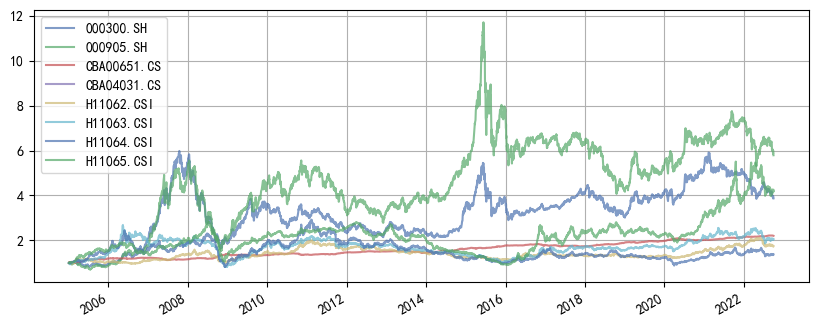

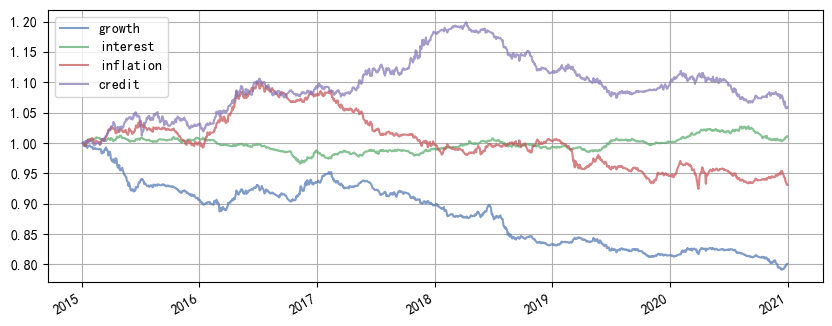

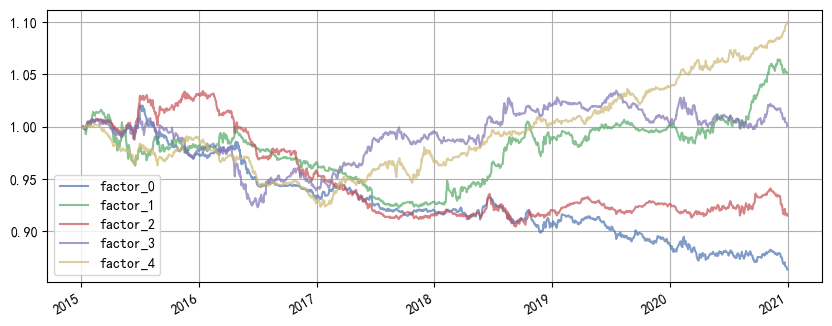

In [5]:
for type_, data in data_dict.items():
    pd.DataFrame({k: v.getRawNavData()/v.getRawNavData().iloc[0] for k,v in data.items()}).plot(figsize=(10,4), grid=True, alpha=0.7)

In [6]:
backtest_args = {
    'date_range': [[2016, 2, 1], [2020, 12, 31]], 
    'frequency': 'monthly', 
    'cash': 1e4, 
    }

strategy_args = {
    'indicator_period': constant_svc.DAY_OF_MONTH*12, 
}

In [7]:
import cvxpy
cvxpy.installed_solvers()

['ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']

In [8]:
portfolio_nav = pd.DataFrame()
asset_weight_dict = {}
for k, v in data_dict.items():
    asset_weight = pd.DataFrame()
    my_backtest_manager = BackTestManager(
        MvoStrategy('test', v, args=strategy_args), # 策略实例
        name = '_', 
        args = backtest_args, 
    )
    my_backtest_manager.backtest()
    portfolio_nav[k] = my_backtest_manager.getDataset().getPositionManager().getHistoricalData().nav

    # 存储结果
    result = {
        'strategy': my_backtest_manager.getDataset().getPositionManager().getHistoricalData(), 
        'assets': my_backtest_manager.getDataset().getGroup('assets').getPositionManager().getHistoricalData(), 
        'orders': my_backtest_manager.getOrderManager().getAllOrders()
    }
    for asset, asset_obj in my_backtest_manager.getDataset().getAllAsset().items():
        result[asset] = asset_obj.getPositionManager().getHistoricalData()

    # writer = pd.ExcelWriter(os.path.join(this_path, 'results_{}.xlsx'.format(factor)))
    # for k, v in result.items():
    #     # print(k)
    #     v.to_excel(writer, k.replace('/', '-'))
    # writer.save()
    # writer.close()

    # weight
    for asset, asset_obj in my_backtest_manager.getDataset().getAllAsset().items():
        asset_weight[asset] = asset_obj.getPositionManager().getHistoricalData().weight
    asset_weight_dict[k] = asset_weight


alg_base.py-line19 INFO: alg test: init args
alg_base.py-line19 INFO: alg _: init args
strategy_base.py-line49 INFO: strategy test: init dataset
backtest_manager.py-line26 INFO: init BackTestManager
backtest_manager.py-line61 INFO: setting date index
backtest_manager.py-line68 INFO: setting init cash
strategy_base.py-line64 INFO: test: init cash
backtest: 100%|██████████| 1198/1198 [00:45<00:00, 26.19days/s]
alg_base.py-line19 INFO: alg test: init args
alg_base.py-line19 INFO: alg _: init args
strategy_base.py-line49 INFO: strategy test: init dataset
backtest_manager.py-line26 INFO: init BackTestManager
backtest_manager.py-line61 INFO: setting date index
backtest_manager.py-line68 INFO: setting init cash
strategy_base.py-line64 INFO: test: init cash
backtest: 100%|██████████| 1198/1198 [00:28<00:00, 42.22days/s]
alg_base.py-line19 INFO: alg test: init args
alg_base.py-line19 INFO: alg _: init args
strategy_base.py-line49 INFO: strategy test: init dataset
backtest_manager.py-line26 INFO

<AxesSubplot:>

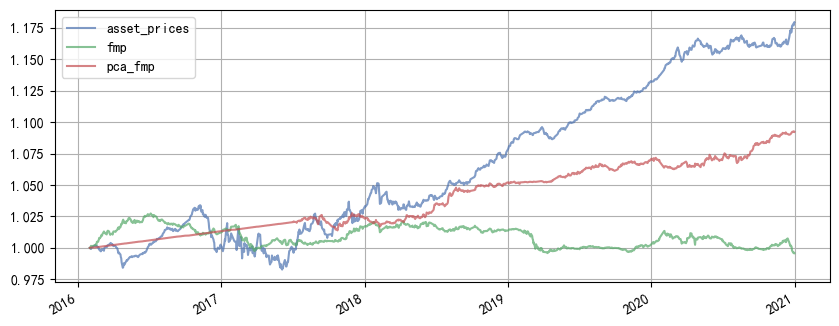

In [9]:
portfolio_nav.plot(figsize=(10,4), grid=True, alpha=0.7)

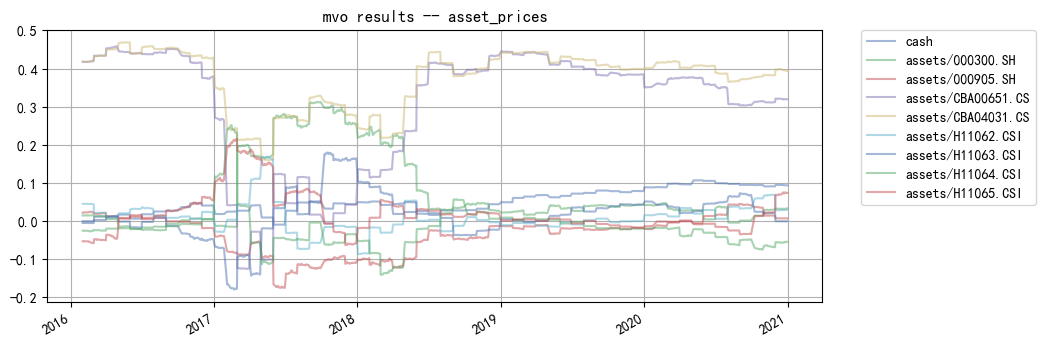

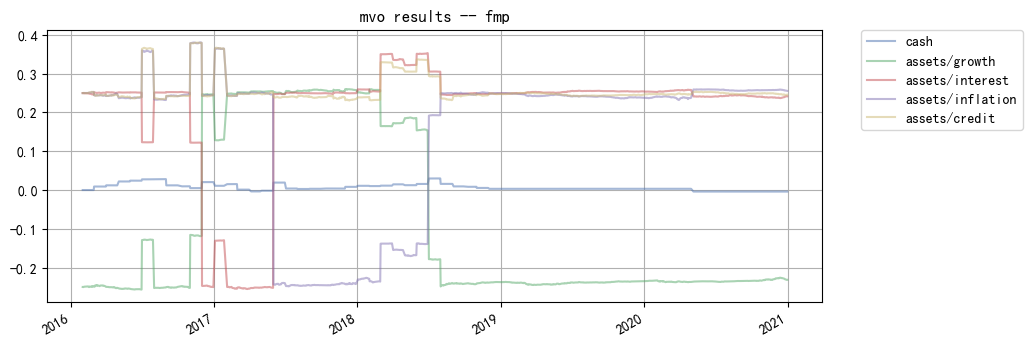

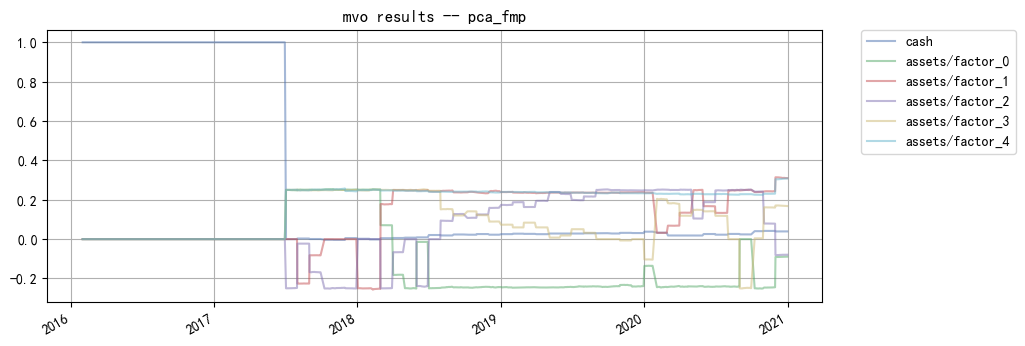

In [10]:
for k, weights in asset_weight_dict.items():
    weights.plot(figsize=(10,4), grid=True, alpha=0.5, title='mvo results -- {}'.format(k))
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)